### How to push to github
##### Write the following in the git terminal:
##### git add *
##### git commit -m "Write the changes in the file that were done here"
##### git push

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kn
from scipy.integrate import quad
import csv
from scipy import optimize
from scipy import integrate
from scipy.integrate import odeint
import pandas as pd

In [237]:
%run CrossSectionFunctions.ipynb

# Particle properties
particle_mass = {
    'Proton': 120,
    'Lambda': 200,
    'Neutron': 100,
    'NeutralPion': 50,
    'ChargedPion': 60,
    'NeutralKaon': 80,
    'ChargedKaon': 90
}


particle_coupling_constants = {
    'NeutralPion': 5e-1
}

particle_ratios = {
    particle: particle_mass[particle] / particle_mass["Lambda"]
    for particle in particle_mass
}

linestyles = {
    "Proton": "-", 
    "Neutron": "--", 
    "Lambda": "-.", 
    "ChargedPion": ":", 
    "NeutralPion": (0, (3, 1, 1, 1)),  # Custom dash pattern
    "ChargedKaon": (0, (5, 2)), 
    "NeutralKaon": (0, (1, 1))
}

None
7.161972439135291e-05
7.161972439135291e-06
7.161972439135291e-07
7.16197243913529e-08
7.161972439135291e-09
7.161972439135291e-10
4.97359197162173e-11


Frozen-out value of Proton with sigma = 2e-09, and mass = 120 GeV is 9.602308618199284e-13
Frozen-out value of Neutron with sigma = 3e-09, and mass = 100 GeV is 2.3949659881179564e-12
Frozen-out value of Lambda with sigma = 1e-07, and mass = 200 GeV is 7.828736238331222e-14
Frozen-out value of NeutralPion with sigma = 4e-09, and mass = 50 GeV is 1.0360627807971514e-10
Frozen-out value of ChargedPion with sigma = 5e-09, and mass = 60 GeV is 3.372219871276658e-11
Frozen-out value of NeutralKaon with sigma = 5e-09, and mass = 80 GeV is 7.405617627274804e-12
Frozen-out value of ChargedKaon with sigma = 6e-09, and mass = 90 GeV is 4.027674504084459e-12
masses =  [120. 100. 200.  50.  60.  80.  90.]
fz [9.60230862e-13 2.39496599e-12 7.82873624e-14 1.03606278e-10
 3.37221987e-11 7.40561763e-12 4.02767450e-12]
Σm_i*Y_i = 8.528967717008188e-09 GeV


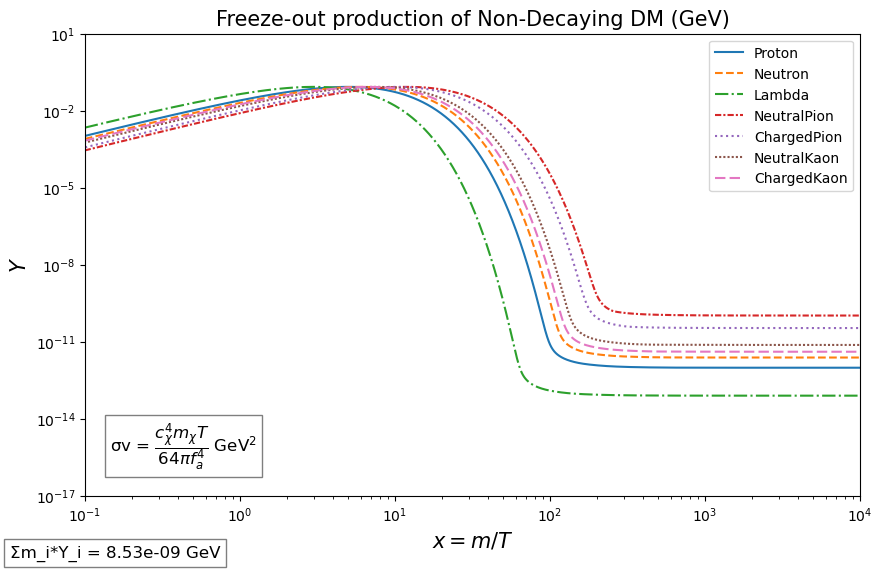

In [263]:
# Integration setup
particles = ["Proton", "Neutron", "Lambda", "NeutralPion", "ChargedPion", "NeutralKaon", "ChargedKaon"]

x_min, x_max = 1e-2, 1E4
x_eval = np.logspace(np.log10(x_min), np.log10(x_max), 10000)

# Plot equilibrium abundance
xx = np.logspace(np.log10(x_min), np.log10(1000), 10000)
#plt.loglog(xx, Y_EQ(xx, 'Proton'), 'c', label=r'$Y_{\rm eq}$, Proton')
plt.figure(figsize=(10, 6))


FreezeOutNumber = np.array([])
masses = np.array([])

for particle in particles:
    cross_section = particle_cross_sections.get(particle, 1)
    mass = particle_mass.get(particle, 1)
    
    #k = fkpractice(x,particle)

    sol = integrate.solve_ivp(
        lambda x, logY: dYdx_logpractice(x, logY, particle),
        (x_min, x_max),
        [np.log(np.array(Y_EQ(x_min, particle)))],  
        method='BDF',  
        t_eval=x_eval,
        rtol=1e-4,
        atol=1e-4,
        jac = None
    )

    #print(sol.y)
    # Convert back from log space
    Y_values = np.exp(sol.y[0])

    print(f'Frozen-out value of {particle} with sigma = {cross_section}, and mass = {mass} GeV is {Y_values[-1]}')

    plt.loglog(sol.t, Y_values, label=f'{particle}',linestyle=linestyles.get(particle, "-"))

    FreezeOutNumber = np.append(FreezeOutNumber, Y_values[-1])
    masses = np.append(masses, mass)

print('masses = ', masses)
print('fz', FreezeOutNumber)
print(f'Σm_i*Y_i = {np.sum(np.multiply(masses,FreezeOutNumber))} GeV')


plt.gcf().text(0.15, 0.15, r"σv = $\dfrac{c_{χ}^{4} m_χT}{64πf_a^4} $ GeV$^{2}$", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5))

plt.ylim(1E-17,10)
plt.xlim(0.1,x_max)
plt.xlabel('$x = m/T$', size= 15)
plt.ylabel('$Y$', size= 15)
plt.title('Freeze-out production of Non-Decaying DM (GeV)', size= 15)
plt.legend()
plt.gcf().text(0.05, 0.001, f"Σm_i*Y_i = {format(np.sum(np.multiply(masses, FreezeOutNumber)), '.2e')} GeV", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5))
#plt.show()
plt.savefig('NonDecayingFreezeOut.png', facecolor = 'w')

In [ ]:

"""
%run FreezeOutFunctions.ipynb
#%run CrossSectionFunctions.ipynb

particle_cross_sections = {
    'Proton': 2e-9,
    'Neutron': 3e-9,
    'Lambda': 1e-7,
    'NeutralPion': 4e-9,
    'ChargedPion': 5e-9,
    'NeutralKaon': 5e-9,
    'ChargedKaon': 6e-9,
}

particle_mass = {
    'Proton': 100,
    'NeutralPion': 1,
}

particle_coupling_constants = {
    'NeutralPion': 1e-1,
}

particles = ['Proton']#["Proton", "Neutron", "Lambda", "ChargedPion", "NeutralPion", "ChargedKaon", "NeutralKaon"]

xmax = 1e2

#plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(8, 6))

x=np.logspace(np.log10(0.1),np.log10(xmax),10000)

FreezeOutNumber = np.array([])
masses = np.array([])

for particle in particles:
    #cross_section = particle_cross_sections.get(particle,1)
    mass = particle_mass.get(particle,1)
    
    Y=integrate.odeint(dYdx,Y_EQ(x[0], particle), x, args=(particle,))
    Decay_rate = AvgDecayRate(x)
    Y_New = Y.reshape(1,-1)
    
    if particle in ("Lambda", "NeutralKaon", "ChargedKaon"):
        Y_Decayed = np.multiply(Y_New,Decay_rate)
        Y_Decayed_New = Y_Decayed.reshape(-1,1)
        FreezeOutNumber = np.append(FreezeOutNumber,Y_Decayed_New[-1])
        #print(f'Frozen-out value of {particle} with sigma = {cross_section}, and mass = {mass} GeV is {Y_Decayed_New[-1]}')
        plt.loglog(x, Y_Decayed_New, label=f'{particle} σv = {cross_section}, m = {mass} GeV', linestyle=linestyles.get(particle, "-"))
        
    else:
        plt.loglog(x, Y, label=f'{particle}: m = {mass} GeV', linestyle=linestyles.get(particle, "-"))
        FreezeOutNumber = np.append(FreezeOutNumber,Y[-1])

        #print(f'Frozen-out value of {particle} with sigma = {cross_section}, and mass = {mass} GeV is {Y[-1]}')
    
    masses = np.append(masses, mass)

#print('Frozen-out values: ', FreezeOutNumber)
#print(f'Particle masses: {masses}')
#print('mult', np.multiply(masses,FreezeOutNumber))
print(f'Σm_i*Y_i = {np.sum(np.multiply(masses,FreezeOutNumber))} GeV')

plt.ylim(1e-10,1e2)
plt.xlim(1e-1,xmax)
plt.xlabel('$x = m/T$', size= 15)
plt.ylabel('$Y$', size= 15)
plt.title('Freeze-out production of Atomic DM GeV', size= 15)
plt.legend()
plt.grid()
plt.gcf().text(0.02, 0.02, f"Σm_i*Y_i = {format(np.sum(np.multiply(masses, FreezeOutNumber)), '.2e')} GeV", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5))
#plt.savefig('Particles.png', facecolor = 'w')
"""

In [ ]:
def lightdom(x):
    return x**(-4)

def matterdom(x):
    return x**(-3)

#plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(10, 6))

T_ex = np.linspace(0.1, 3, num = 10000)

Y_lightdom = lightdom(T_ex)
Y_matterdom = matterdom(T_ex)

plt.axvline(1, alpha = 0.5, linewidth = 0.5, color = 'black')
plt.axvline(2.15, alpha = 0.5, linewidth = 0.5, color = 'black')
plt.axhline(1e-1, linewidth = 1, color = 'darkgreen', label = 'Vacuum Energy')
plt.plot(T_ex,Y_lightdom, label = 'Radiation', color = 'darkred',linewidth = 1)
plt.plot(T_ex, Y_matterdom, label = 'Matter', color = 'indigo', linewidth = 1)
plt.legend()
plt.xlabel('Time scale (arb. units)')
plt.ylabel('Relative density  (arb. units)')
plt.yscale('log')
plt.text(1.3,1e3,"Matter dominated universe", bbox=dict(facecolor='white', alpha=0.5), size = 'x-small')
plt.text(0.225,1e3,"Radiation dominated universe", bbox=dict(facecolor='white', alpha=0.5), size = 'x-small')
plt.text(2.3,1e3,"Vacuum Energy dominated universe", bbox=dict(facecolor='white', alpha=0.5), size = 'x-small')

#plt.grid(linestyle = '--')
#plt.ylim(0,3)
#plt.savefig('TimeScaleArb.png')

In [ ]:
print(thermally_averaged_cross_section(10, "Proton"))

In [ ]:
"""
particle_ratios = {
    "ChargedPion": R_CP,
    "ChargedKaon": R_CK,
    "NeutralPion": R_NP,
    "NeutralKaon": R_NK,
    "Lambda": R_L,
    "Proton": R_P,
    "Neutron": R_N,
    "TestMeson": R_testMeson,
    "TestBaryon": R_testBaryon
}

particle_mass = {
    'Proton': 1e-5,
    'Neutron': 1e-5,
    'Lambda': 1e-3,
    'ChargedPion': 1e-7,
    'NeutralPion': 1e-7,
    'ChargedKaon': 1e-6,
    'NeutralKaon': 1e-6,
    'TestBaryon': 1e-5,
    'TestMeson': 1e-5,
}

particle_cross_sections = {
    'Proton': 1e-8,
    'Neutron': 1e-8,
    'Lambda': 1e-9,
    'ChargedPion': 1e-10,
    'NeutralPion': 1e-10,
    'ChargedKaon': 1e-10,
    'NeutralKaon': 1e-10,
    "TestMeson": 1e-7
}

particle_mass = {
    'Proton': 1e-10,
    'Neutron': 1e-10,
    'Lambda': 1e-9,
    'ChargedPion': 1e-11,
    'NeutralPion': 1e-11,
    'ChargedKaon': 0.5e-10,
    'NeutralKaon': 0.5e-10,
}

particle_cross_sections = {
    'Proton': 1e-6,
    'Neutron': 1e-6,
    'Lambda': 1e-9,
    'ChargedPion': 1e-5,
    'NeutralPion': 1e-6,
    'ChargedKaon': 1e-6,
    'NeutralKaon': 1e-7,
}


particle_mass = {
    'Proton': 1e-5,
    'Neutron': 5e-4,
    'Lambda': 5e-4,
    'ChargedPion': 1e-8,
    'NeutralPion': 5e-9,
    'ChargedKaon': 1e-6,
    'NeutralKaon': 5e-6,
    'TestBaryon': 1e-5,
    'TestMeson': 1e-5,
}

particle_cross_sections = {
    'Proton': 1e-8,
    'Neutron': 1e-8,
    'Lambda': 1e-7,
    'ChargedPion': 1e-13,
    'NeutralPion': 1e-13,
    'ChargedKaon': 1e-10,
    'NeutralKaon': 1e-10,
    "TestMeson": 1e-7
}


##this one works for decaying particles
particle_mass = {
    'Proton': 1e-6,
    'Neutron': 1e-5,
    'Lambda': 1e-6,
    'ChargedPion': 1e-7,
    'NeutralPion': 1e-6,
    'ChargedKaon': 0.5e-8,
    'NeutralKaon': 1e-8,
}

particle_cross_sections = {
    'Proton': 0.5e-7,
    'Neutron': 1e-7,
    'Lambda': 1e-9,
    'ChargedPion': 0.5e-5,
    'NeutralPion': 1e-5,
    'ChargedKaon': 0.5e-6,
    'NeutralKaon': 1e-6,
}


# PARTICLE RATIOS TO SCALE THE X VALUES. EVERYTHING IS SCALED BASED OFF THE NEUTRAL PION AS IT IS THE LIGHTEST HADRON
R_NP = particle_mass.get("NeutralPion")/particle_mass.get("Lambda")
R_CP = particle_mass.get("ChargedPion")/particle_mass.get("Lambda")
R_NK = particle_mass.get("NeutralKaon")/particle_mass.get("Lambda")
R_CK = particle_mass.get("ChargedKaon")/particle_mass.get("Lambda")
R_L = 1
R_P = particle_mass.get("Proton")/particle_mass.get("Lambda")
R_N = particle_mass.get("Neutron")/particle_mass.get("Lambda")

particle_ratios = {
    "ChargedPion": R_CP,
    "ChargedKaon": R_CK,
    "NeutralPion": R_NP,
    "NeutralKaon": R_NK,
    "Lambda": R_L,
    "Proton": R_P,
    "Neutron": R_N,
}
"""

In [ ]:
"""
# Load the data
Gstar_df = pd.read_csv("Gstar.csv", header = None)
GstarS_df = pd.read_csv("GstarS.csv", header = None)

# Convert to dictionaries while preserving order
Gstar = dict(zip(Gstar_df.iloc[:, 0], Gstar_df.iloc[:, 1]))
GstarS = dict(zip(GstarS_df.iloc[:, 0], GstarS_df.iloc[:, 1]))


# Extract temperature values and corresponding function values in original order
temps_Gstar = Gstar_df.iloc[:, 0].values  # Keep order from CSV
values_Gstar = np.flip(Gstar_df.iloc[:, 1].values)  

temps_GstarS = GstarS_df.iloc[:, 0].values  # Keep order from CSV
values_GstarS = np.flip(GstarS_df.iloc[:, 1].values)  

# Plot the functions
plt.figure(figsize=(8, 6))
plt.plot(temps_Gstar, values_Gstar, label="$g_*$", linestyle="-")
plt.plot(temps_GstarS, values_GstarS, label="$g_{*S}$", linestyle="--")
plt.xscale('log')

plt.yscale('log')

# Labels and title
plt.xlabel("Temperature")
plt.ylabel("$g_*$ and $g_{*S}$")
plt.title("Evolution of $g_*$ and $g_{*S}$ with Temperature")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
"""